#### This notebook explores how different types of noise and outliers can affect clustering algorithms. We implement and compare various noise injection strategies — from simple uniform outliers to more statistically grounded and subtle multivariate perturbations. By visualizing and analyzing each method, we aim to understand how realistic or adversarial noise can challenge the reliability and robustness of unsupervised learning techniques.

#Setup Environment

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
import itertools
import copy
from sklearn.cluster import DBSCAN, HDBSCAN, KMeans
from sklearn.datasets import make_blobs
from sklearn import datasets
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [2]:
def plot(df, labels, probabilities=None, parameters=None, ground_truth=False, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 4))

    # Fallbacks
    labels = np.array(labels) if labels is not None else np.ones(len(df))
    probabilities = np.array(probabilities) if probabilities is not None else np.ones(len(df))

    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = [0, 0, 0, 1]  # Noise is black

        class_members = (labels == k)
        for i, row in df[class_members].iterrows():
            ax.plot(
                row.iloc[0],  # First column as x
                row.iloc[1],  # Second column as y
                "x" if k == -1 else "o",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=4 if k == -1 else 1 + 5 * probabilities[i],
            )

    n_clusters_ = len(unique_labels) - (1 if -1 in unique_labels else 0)
    preamble = "True" if ground_truth else "Estimated"
    title = f"{preamble} number of clusters: {n_clusters_}"
    if parameters is not None:
        title += " | " + ", ".join(f"{k}={v}" for k, v in parameters.items())

    ax.set_title(title)
    plt.tight_layout()

In [3]:
def plot_feature_pairs(df, figsize=(16, 12)):
    features = df['data'].columns.tolist()
    feature_pairs = list(itertools.combinations(features, 2))

    plt.figure(figsize=figsize)
    for i, (x_feat, y_feat) in enumerate(feature_pairs, 1):
        plt.subplot(2, 3, i)
        for label in df['target_names']:
            subset = df['frame'][df['frame']['target'] == df['target_names'].tolist().index(label)]
            plt.scatter(subset[x_feat], subset[y_feat], label=label, alpha=0.7)
        plt.xlabel(x_feat)
        plt.ylabel(y_feat)
        plt.title(f'{x_feat} vs {y_feat}')
        plt.legend()
    plt.tight_layout()
    plt.show()

##Load Iris Dataset

In [4]:
df_iris = datasets.load_iris(as_frame=True)

#Original data and its distribution visualization

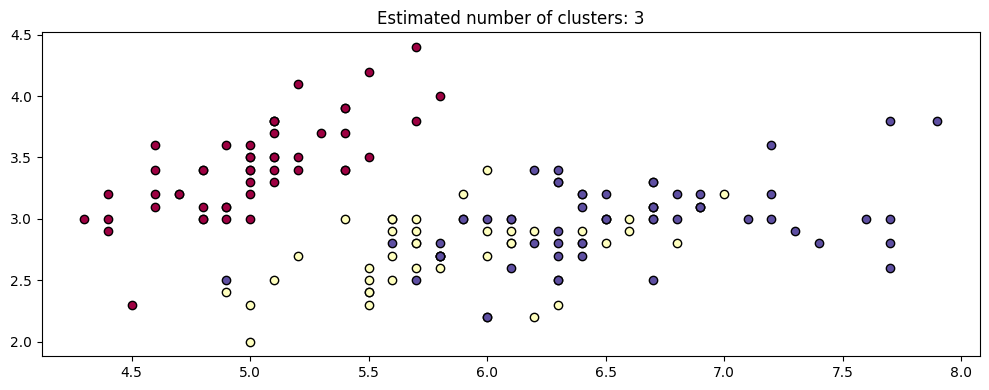

In [5]:
plot(df_iris['data'], labels=df_iris['target'])

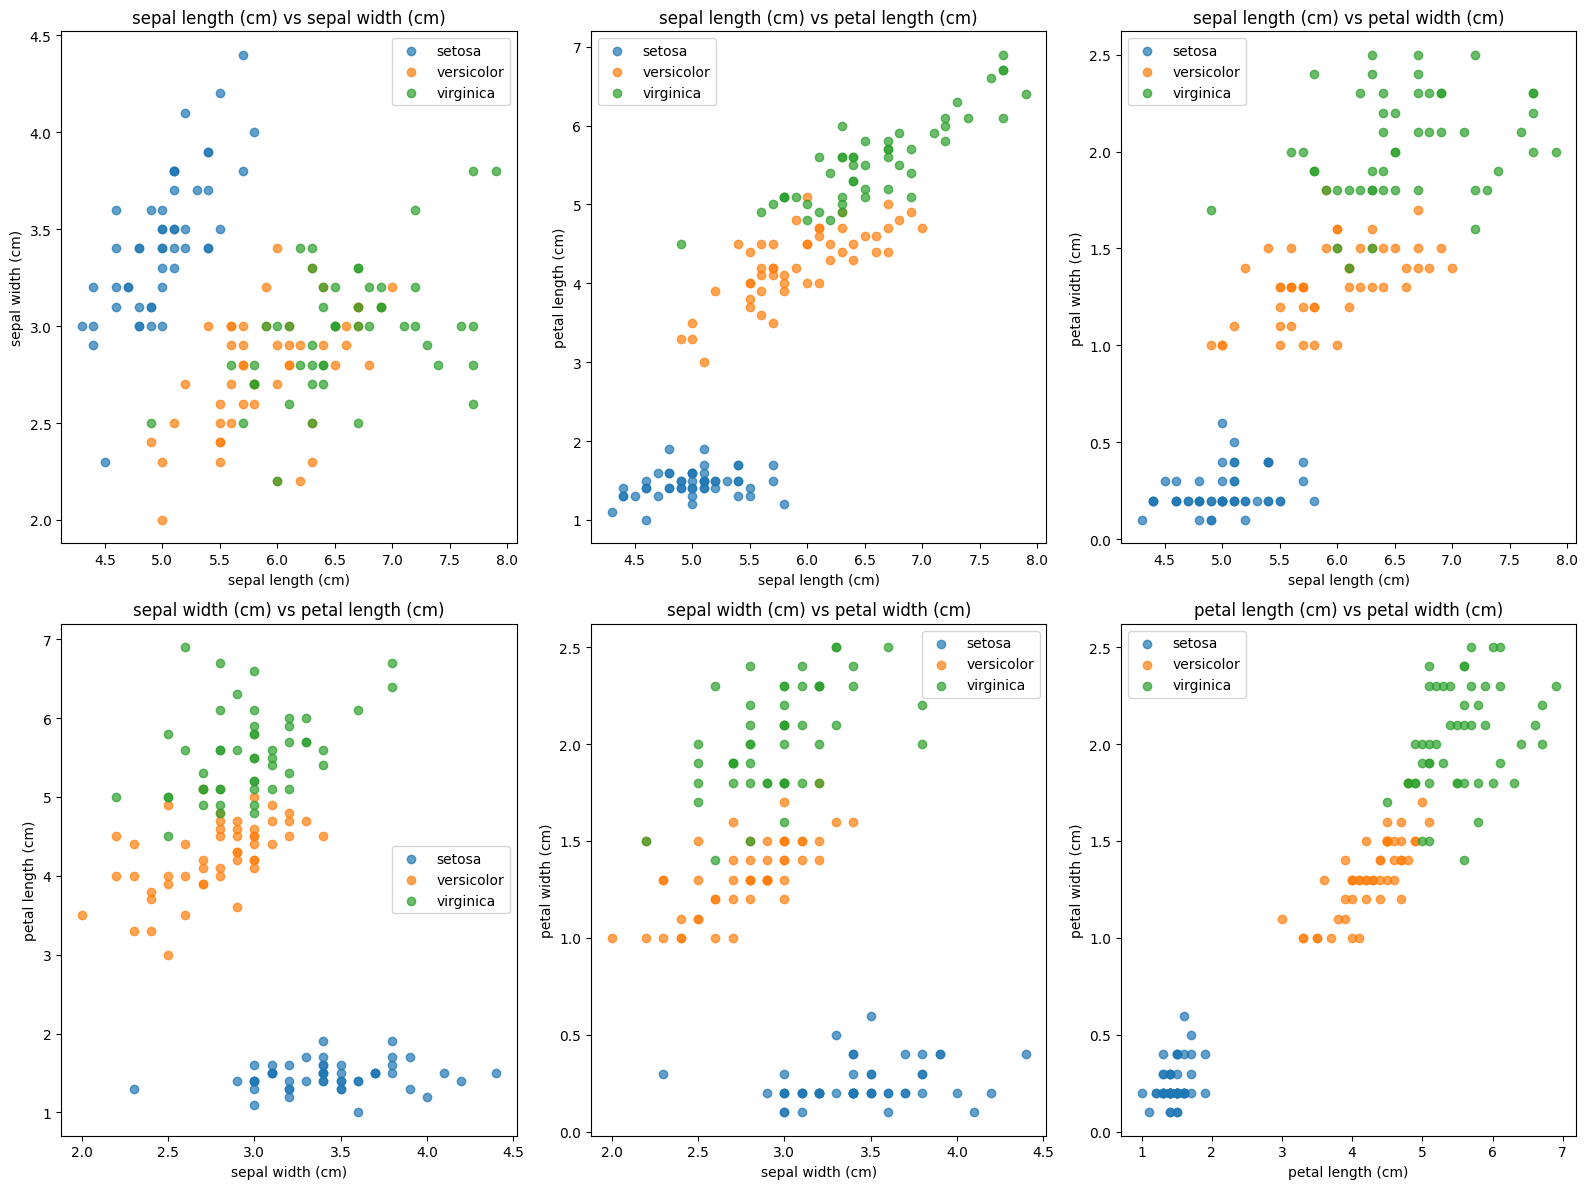

In [6]:
plot_feature_pairs(df_iris, figsize=(16, 12))

#Modified data and its distribution visualization

##Added some random Gaussian noise to the whole data, no more instances were added

Added some random Gaussian noise to the whole data, no more instances were added. This method makes the clusters more "fuzzy", making the boundary between two clusters less visible, disturbing the intra-cluster and inter-cluster distances.

In [7]:
df_noisy = copy.deepcopy(df_iris)
noise = np.random.normal(loc=0, scale=0.2, size=df_noisy['frame'].iloc[:, :4].shape)
df_noisy['data'].iloc[:, :4] += noise
df_noisy['frame'].iloc[:, :4] += noise

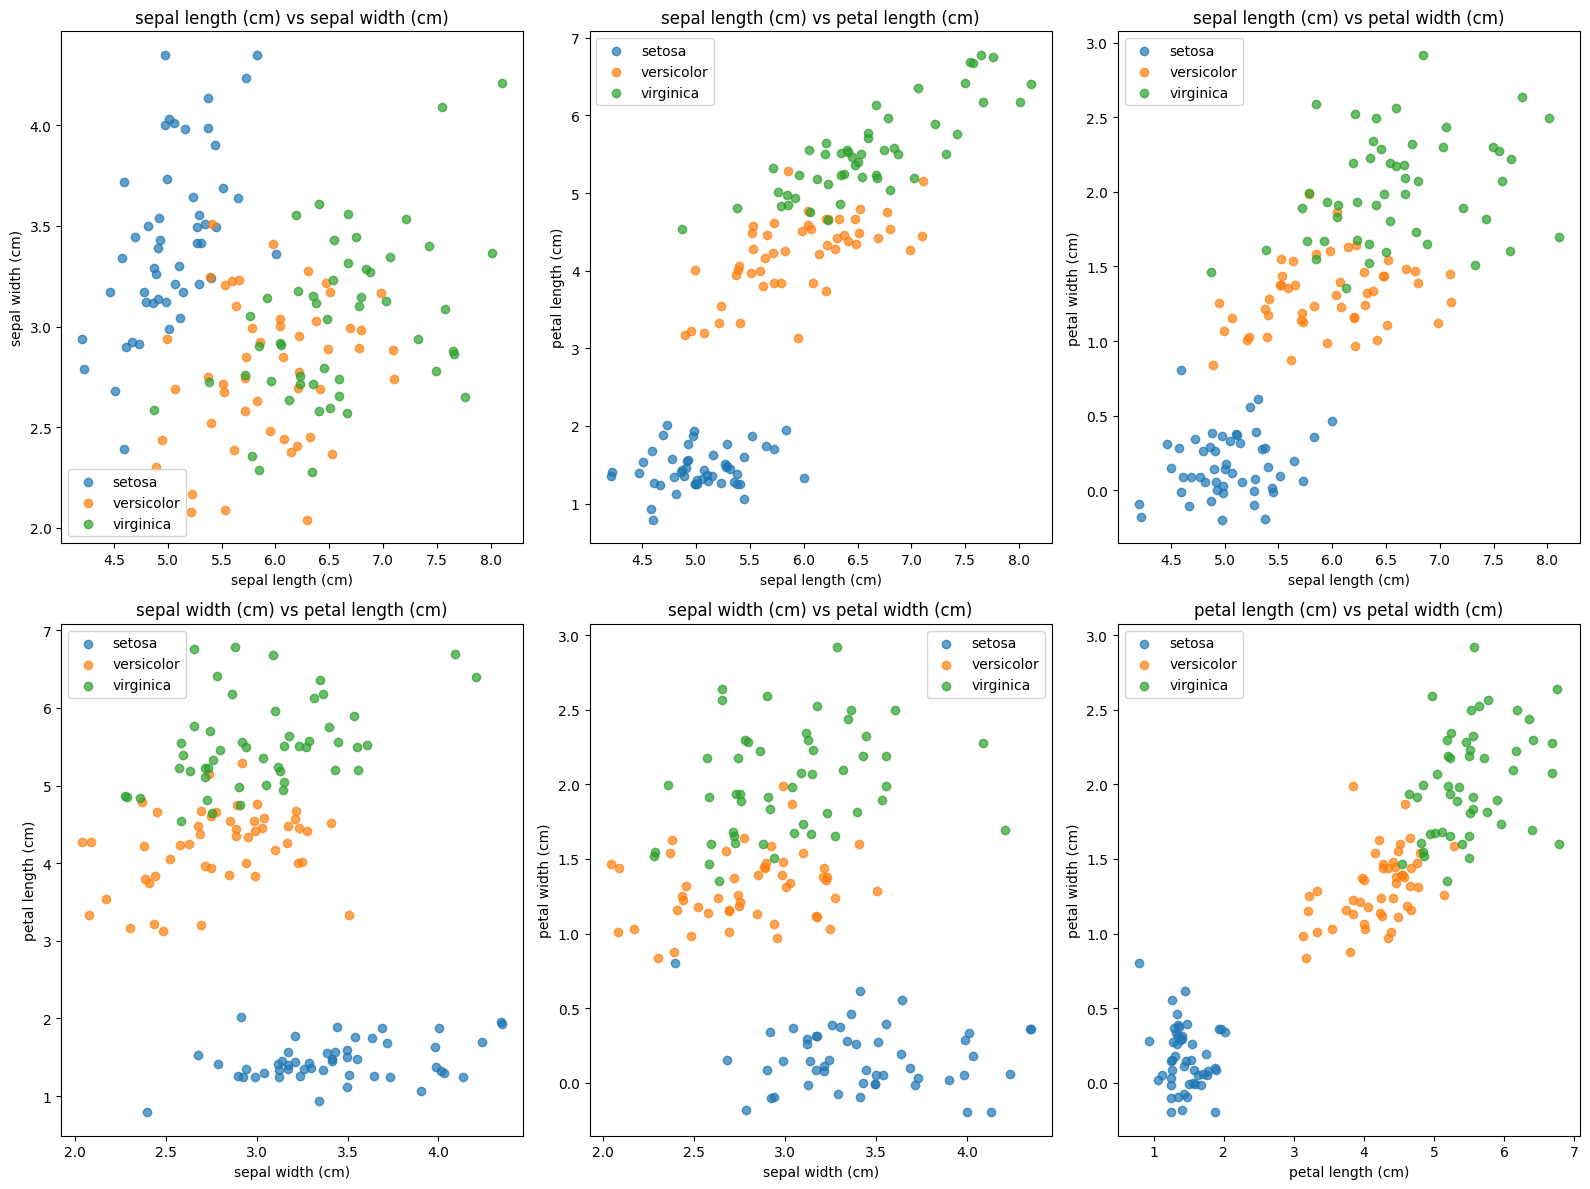

In [8]:
plot_feature_pairs(df_noisy, figsize=(16, 12))

##Added outliers based on inital guess for the data

Outliers are generated using fixed uniform ranges far outside the observed data. This method creates extreme values that are easy to detect, making them suitable for testing robust clustering algorithms. However, they may not reflect realistic noise patterns.

In [9]:
outliers = pd.DataFrame({
    'sepal length (cm)': np.random.uniform(10, 15, 5),
    'sepal width (cm)': np.random.uniform(5, 10, 5),
    'petal length (cm)': np.random.uniform(10, 15, 5),
    'petal width (cm)': np.random.uniform(5, 10, 5)
})
target = pd.DataFrame({'target': [3] * 5})
df_outlier = copy.deepcopy(df_iris)
df_outlier['data'] = pd.concat([df_iris['data'], outliers], ignore_index=True)
df_outlier['frame'] = pd.concat([df_iris['frame'], pd.concat([outliers, target], axis=1)], ignore_index=True)
df_outlier['target_names'] = np.append(df_outlier['target_names'], ['noise'])

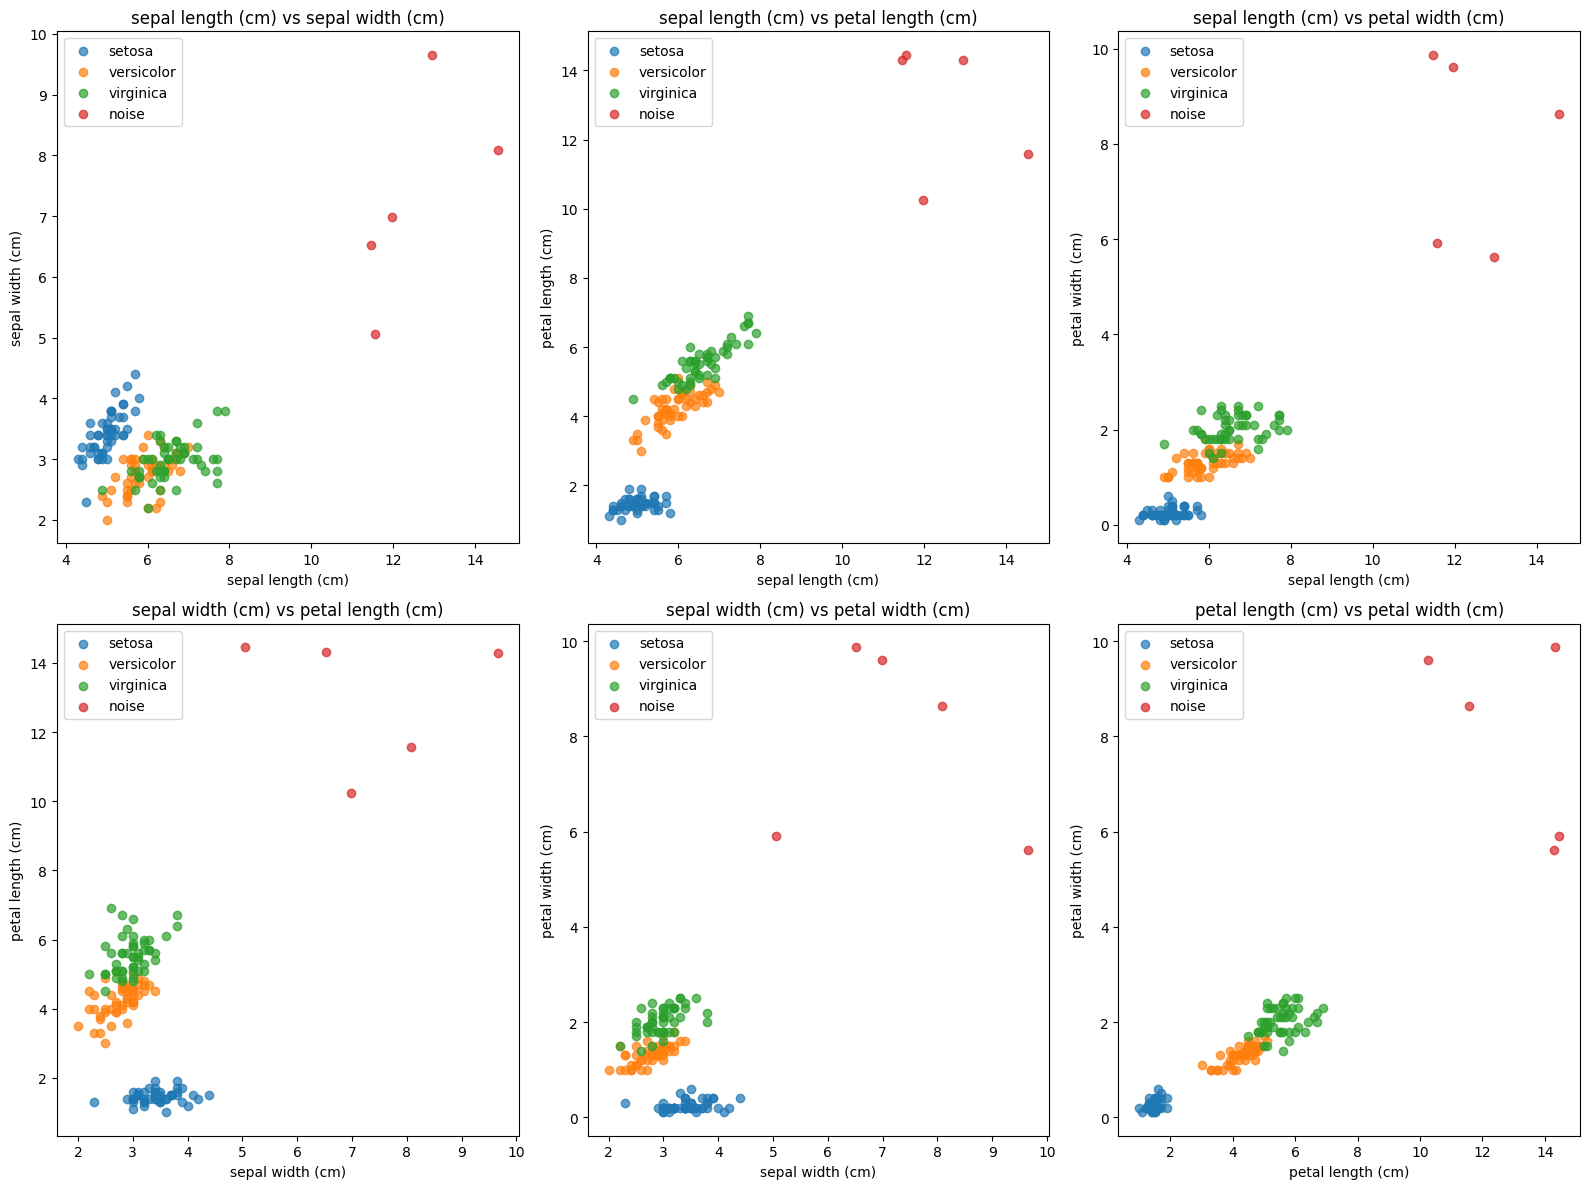

In [10]:
plot_feature_pairs(df_outlier, figsize=(16, 12))

##Added subtle outliers that blend into existing data points

In [11]:
def generate_subtle_outliers(df, n_outliers=5, exaggeration_factor=1.5, random_state=42):
    """
    Generate subtle multivariate outliers based on the covariance structure of the dataset.

    Parameters:
        df (pd.DataFrame): Original dataset.
        n_outliers (int): Number of outliers to generate.
        exaggeration_factor (float): How far from the mean the outliers should be (in standard deviations).
        random_state (int): Seed for reproducibility.

    Returns:
        pd.DataFrame: New dataframe including subtle outliers.
    """
    np.random.seed(random_state)
    features = df['data'].columns
    df_features = df['data'][features]

    #mean and covariance
    mean_vec = df_features.mean().values
    cov_matrix = np.cov(df_features.T)

    #generate multivariate normal noise scaled from the mean
    outliers = np.random.multivariate_normal(
        mean=mean_vec,
        cov=cov_matrix,
        size=n_outliers
    )
    #scale away from the mean to make them more "unusual", but not extreme
    centered_outliers = outliers - mean_vec
    outliers_scaled = mean_vec + exaggeration_factor * centered_outliers

    outlier_df = copy.deepcopy(df)
    outlier_df['data'] = pd.concat([df['data'], pd.DataFrame(outliers_scaled, columns=features)], ignore_index=True)
    outlier_df['frame'] = pd.DataFrame(outliers_scaled, columns=features)
    outlier_df['frame']['target'] = outlier_df['target'].apply(lambda x: 3)
    outlier_df['target_names'] = np.append(outlier_df['target_names'], ['noise'])
    outlier_df['frame'] = pd.concat([df['frame'], outlier_df['frame']], ignore_index=True)

    return outlier_df

Outliers are generated using a multivariate normal distribution derived from the dataset's covariance structure and scaled slightly away from the mean. This method introduces realistic but misleading data points that respect the data's internal correlations. These outliers are hard to distinguish, making them excellent for testing clustering robustness under realistic noise.

Subtle outliers are harder to detect and can only be spotted on the plots due to the highlighting. Choosing the right amount can have a larger negative effect on the dataset. Carefully choosing there position e.g planting them on the border of two clusters can also blend previously separate clusters together if the algorithm prevents it.

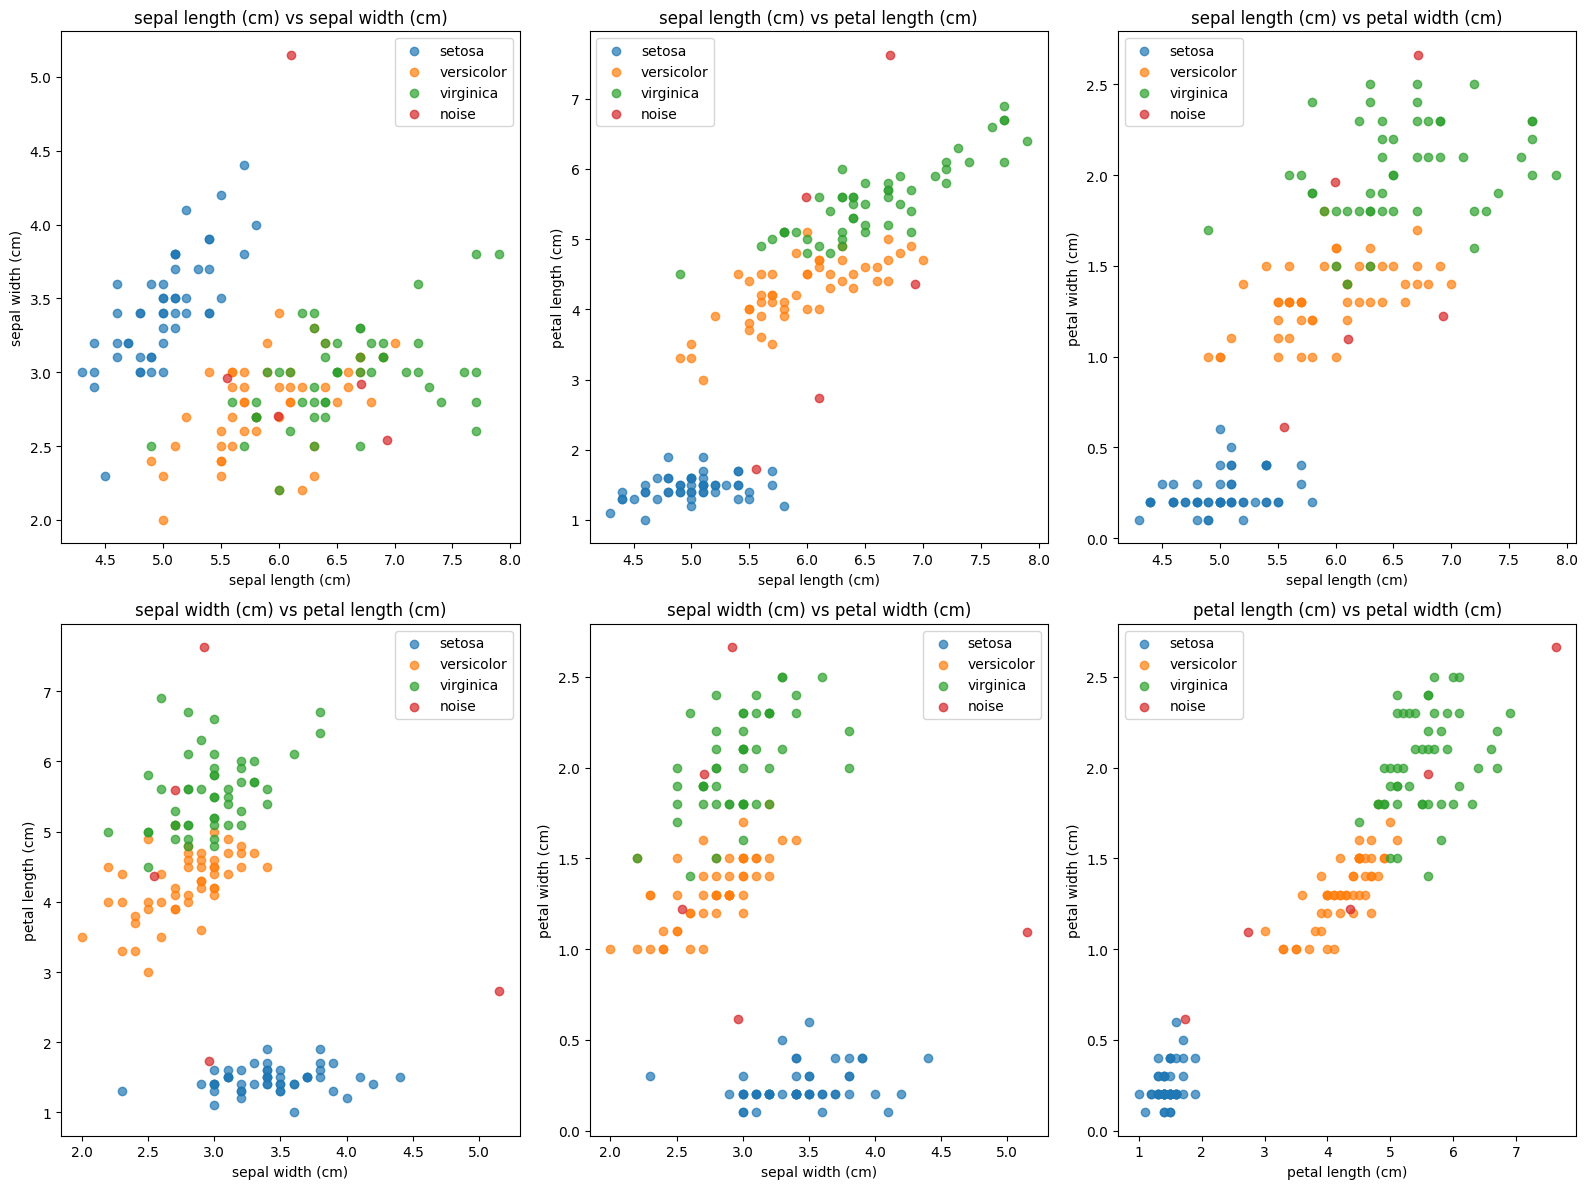

In [12]:
df_subtle_outliers = generate_subtle_outliers(df_iris, n_outliers=5, exaggeration_factor=2)
plot_feature_pairs(df_subtle_outliers, figsize=(16, 12))

##Shuffeled the data, 20% of the labels were shuffled

In this method, 20% of the dataset's class labels are randomly shuffled to introduce label noise. This simulates mislabeling errors or ambiguous instances that could misguide clustering evaluation or semi-supervised learning techniques. The underlying feature vectors remain unchanged, making this a subtle but impactful form of disturbance.

In [13]:
df_label_shuffled = copy.deepcopy(df_iris)

np.random.seed(42)
fraction_to_shuffle = 0.2
num_to_shuffle = int(fraction_to_shuffle * len(df_label_shuffled['frame']))

indices_to_shuffle = np.random.choice(df_label_shuffled['frame'].index, size=num_to_shuffle, replace=False)

shuffled_labels = np.random.permutation(df_label_shuffled['frame'].loc[indices_to_shuffle, 'target'].values)
df_label_shuffled['frame'].loc[indices_to_shuffle, 'target'] = shuffled_labels

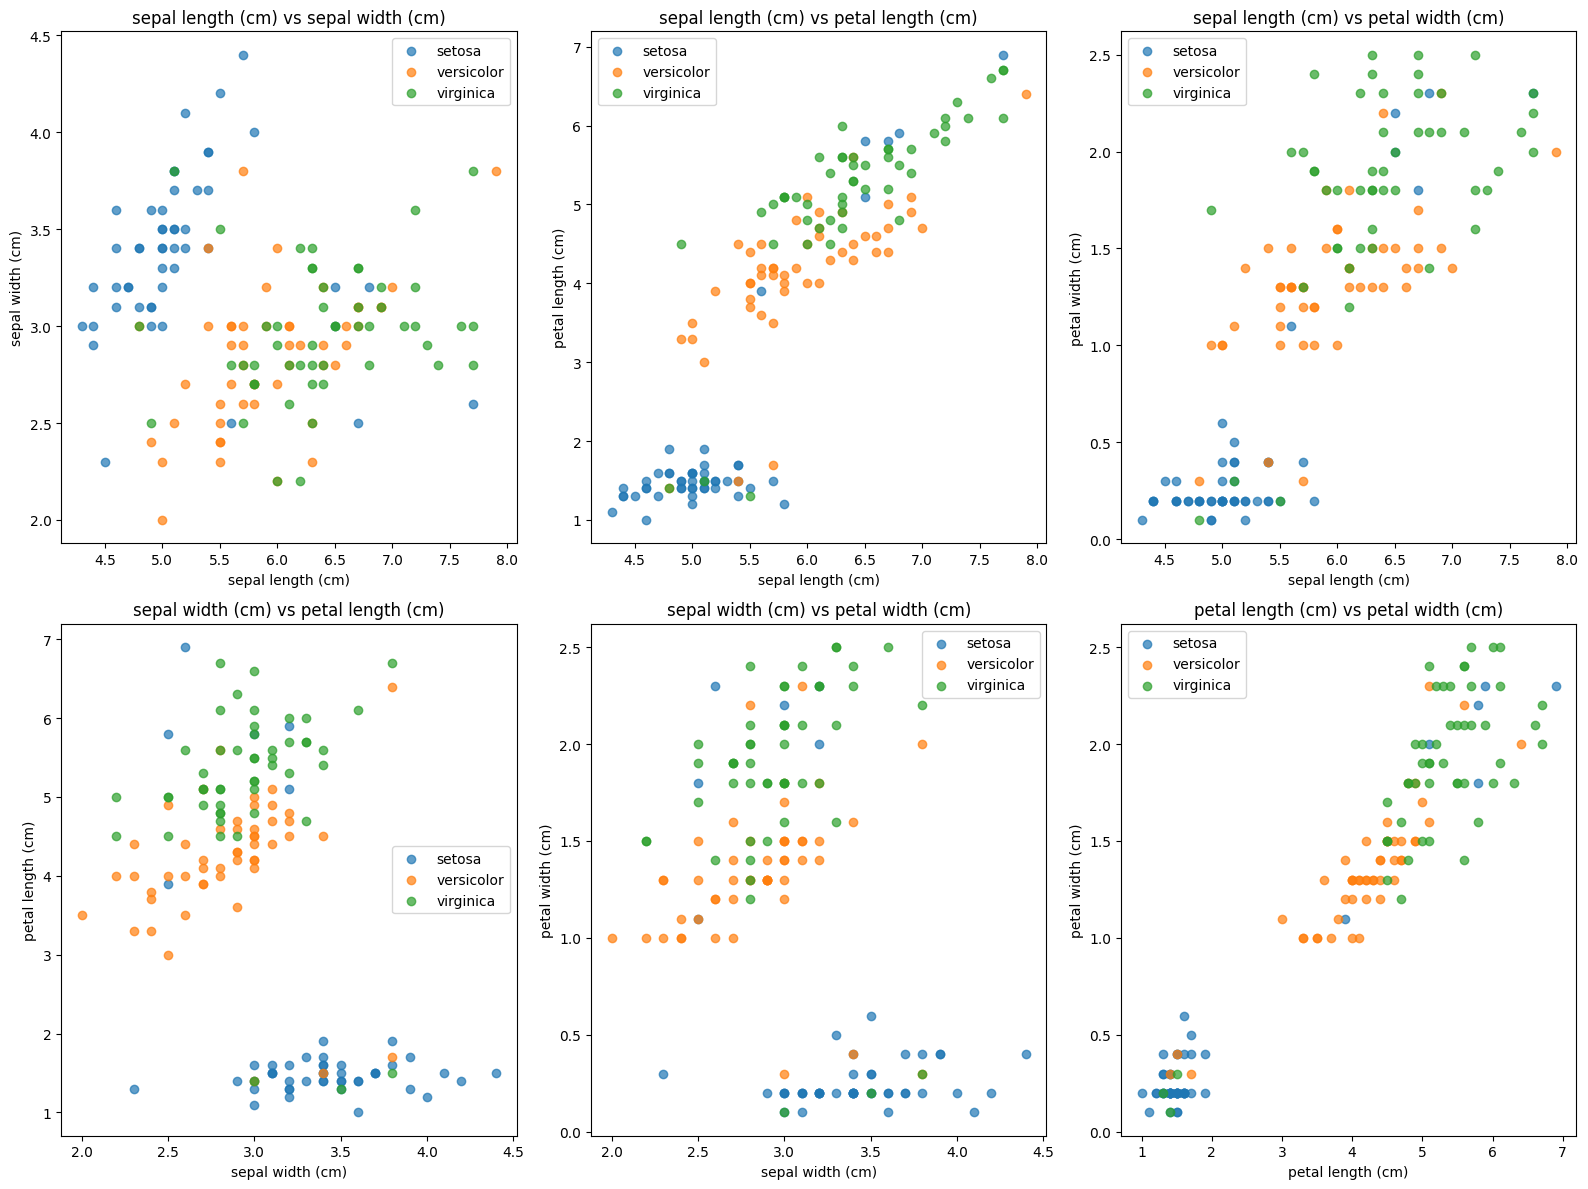

In [14]:
plot_feature_pairs(df_label_shuffled, figsize=(16, 12))

#Clustering

In [15]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)

##Initial Clustering Without Poisoning

In [16]:
y_kmeans_origin = kmeans.fit_predict(df_iris['data'])

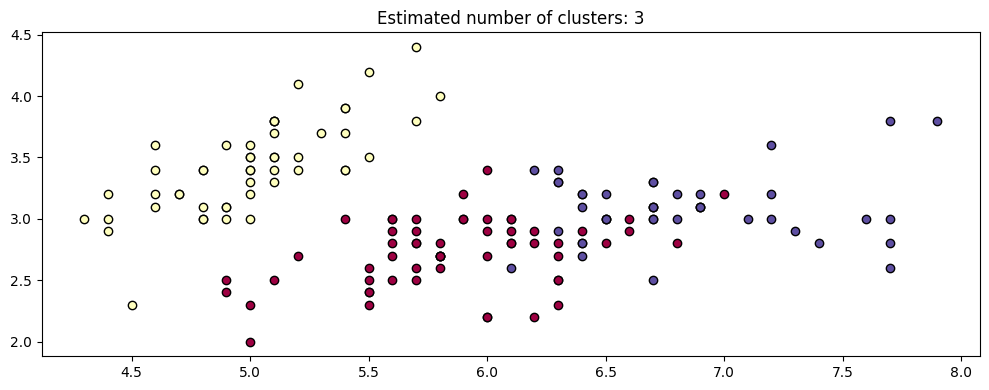

In [17]:
plot(df_iris['data'], y_kmeans_origin)

In [18]:
silhouette_avg_origin = silhouette_score(df_iris['data'], y_kmeans_origin)
print(f"Silhouette Score: {silhouette_avg_origin}")

calinski_harabasz_origin = calinski_harabasz_score(df_iris['data'], y_kmeans_origin)
print(f"Calinski-Harabasz Index: {calinski_harabasz_origin}")

davies_bouldin_origin = davies_bouldin_score(df_iris['data'], y_kmeans_origin)
print(f"Davies-Bouldin Index: {davies_bouldin_origin}")

Silhouette Score: 0.5528190123564102
Calinski-Harabasz Index: 561.62775662962
Davies-Bouldin Index: 0.6619715465007465


##Clustering on data with random noise

Random noise seems to skew the clustering quite a bit. The original clusters are still visible on the plot, but the metrics reveal a worse performance than the original.

In [19]:
y_kmeans_noisy = kmeans.fit_predict(df_noisy['data'])

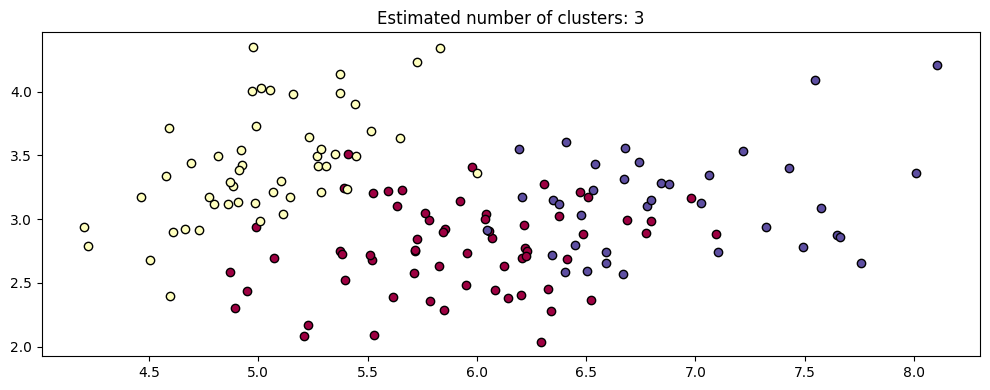

In [20]:
plot(df_noisy['data'], y_kmeans_noisy)

In [21]:
silhouette_avg_noisy = silhouette_score(df_noisy['data'], y_kmeans_noisy)
print(f"Silhouette Score: {silhouette_avg_noisy}")

calinski_harabasz_noisy = calinski_harabasz_score(df_noisy['data'], y_kmeans_noisy)
print(f"Calinski-Harabasz Index: {calinski_harabasz_noisy}")

davies_bouldin_noisy = davies_bouldin_score(df_noisy['data'], y_kmeans_noisy)
print(f"Davies-Bouldin Index: {davies_bouldin_noisy}")

Silhouette Score: 0.5164461762402804
Calinski-Harabasz Index: 444.0583813321562
Davies-Bouldin Index: 0.7340778038726107


##Clustering on data with outliers based on initial guess

Due to the new data points being distant and the nature of K-means (fixed number of clusters and no ability to detect noise) the results do not look like the original. The metrics however show a better score overall, due to the generated outliers being their own cluster and so distant that they appear well separated. Due to these reasons, they would be easy to detect with outlier and anomaly detection methods.

In [22]:
y_kmeans_outlier = kmeans.fit_predict(df_outlier['data'])

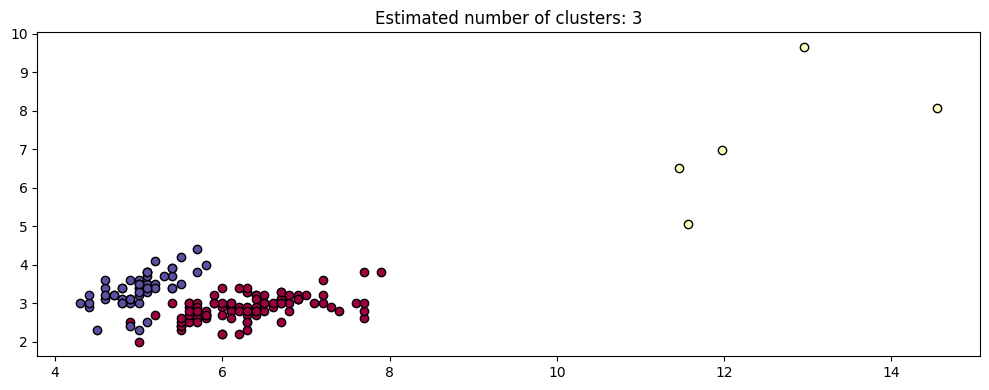

In [23]:
plot(df_outlier['data'], y_kmeans_outlier)

In [24]:
silhouette_avg_outlier = silhouette_score(df_outlier['data'], y_kmeans_outlier)
print(f"Silhouette Score: {silhouette_avg_outlier}")

calinski_harabasz_outlier = calinski_harabasz_score(df_outlier['data'], y_kmeans_outlier)
print(f"Calinski-Harabasz Index: {calinski_harabasz_outlier}")

davies_bouldin_outlier = davies_bouldin_score(df_outlier['data'], y_kmeans_outlier)
print(f"Davies-Bouldin Index: {davies_bouldin_outlier}")

Silhouette Score: 0.6790634634217514
Calinski-Harabasz Index: 547.6358382122479
Davies-Bouldin Index: 0.37859466653884394


##Clustering on data with subtle outliers

Subtle outliers as expected, blend into the data much more. Due to the small number of new data introduced, the metrics are not that much worse compared to the original.

In [25]:
y_kmeans_subtle = kmeans.fit_predict(df_subtle_outliers['data'])

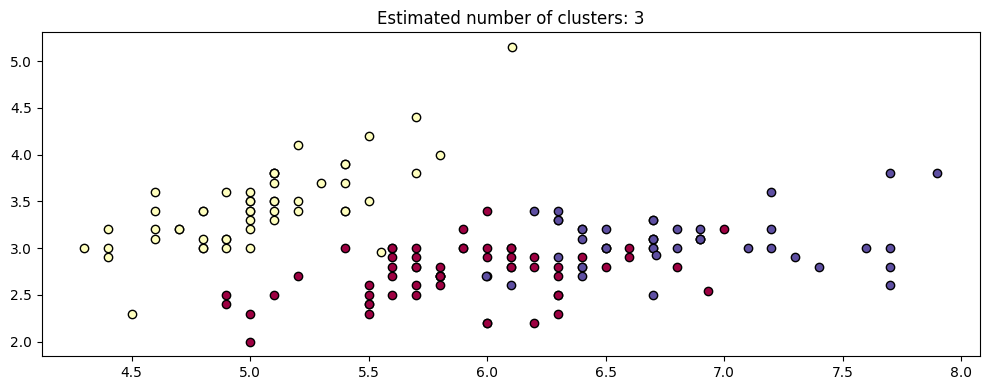

In [26]:
plot(df_subtle_outliers['data'], y_kmeans_subtle)

In [27]:
silhouette_avg_subtle = silhouette_score(df_subtle_outliers['data'], y_kmeans_subtle)
print(f"Silhouette Score: {silhouette_avg_subtle}")

calinski_harabasz_subtle = calinski_harabasz_score(df_subtle_outliers['data'], y_kmeans_subtle)
print(f"Calinski-Harabasz Index: {calinski_harabasz_subtle}")

davies_bouldin_subtle = davies_bouldin_score(df_subtle_outliers['data'], y_kmeans_subtle)
print(f"Davies-Bouldin Index: {davies_bouldin_subtle}")

Silhouette Score: 0.5408056262065762
Calinski-Harabasz Index: 515.9775140818493
Davies-Bouldin Index: 0.6799655805428602


##Clustering on data with shuffled labels

Shuffling the labels has no effect on the clustering itself because of its unsupervised nature. However, it could be an effective attack when the larger machine learning solution depends on the groun throuth in some other way (i.e semi-supervised learning).

In [28]:
y_kmeans_shuffled = kmeans.fit_predict(df_label_shuffled['data'])

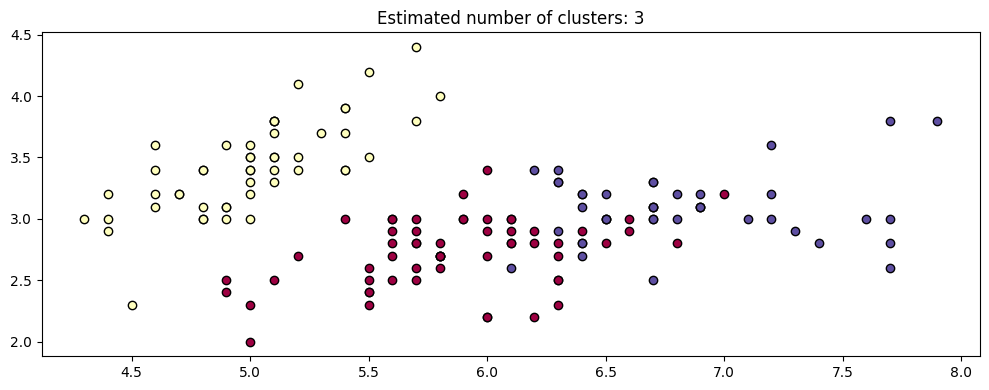

In [29]:
plot(df_label_shuffled['data'], y_kmeans_shuffled)

In [30]:
silhouette_avg_shuffled = silhouette_score(df_label_shuffled['data'], y_kmeans_shuffled)
print(f"Silhouette Score: {silhouette_avg_shuffled}")

calinski_harabasz_shuffled = calinski_harabasz_score(df_label_shuffled['data'], y_kmeans_shuffled)
print(f"Calinski-Harabasz Index: {calinski_harabasz_shuffled}")

davies_bouldin_shuffled = davies_bouldin_score(df_label_shuffled['data'], y_kmeans_shuffled)
print(f"Davies-Bouldin Index: {davies_bouldin_shuffled}")

Silhouette Score: 0.5528190123564102
Calinski-Harabasz Index: 561.62775662962
Davies-Bouldin Index: 0.6619715465007465


#Evaluate Clustering

In [31]:
metrics = pd.DataFrame({
    "Original": [silhouette_avg_origin, calinski_harabasz_origin, davies_bouldin_origin],
    "Noisy": [silhouette_avg_noisy, calinski_harabasz_noisy, davies_bouldin_noisy],
    "Outlier": [silhouette_avg_outlier, calinski_harabasz_outlier, davies_bouldin_outlier],
    "Subtle": [silhouette_avg_subtle, calinski_harabasz_subtle, davies_bouldin_subtle],
    "Shuffled": [silhouette_avg_shuffled, calinski_harabasz_shuffled, davies_bouldin_shuffled]
}, index = ['Silhouette Score', 'Calinski-Harabasz Index', 'Davies-Bouldin Index'])
metrics

,Original,Noisy,Outlier,Subtle,Shuffled
Silhouette Score,0.552819,0.516446,0.679063,0.540806,0.552819
Calinski-Harabasz Index,561.627757,444.058381,547.635838,515.977514,561.627757
Davies-Bouldin Index,0.661972,0.734078,0.378595,0.679966,0.661972


##Conclusion
Internal clustering metrics can be misleading in adversarial settings. While they may show artificially inflated values when noise is extreme and separable, subtle attacks degrade cluster quality more stealthily. Therefore, visual inspection, domain knowledge, and robust clustering techniques are essential when working in potentially poisoned environments.